In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import shap

# load JS visualization code to notebook
shap.initjs()

In [2]:
# https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
df = pd.read_csv('heart_failure_clinical_records.csv')
print(df.shape)
df.head(2)

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1


In [3]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

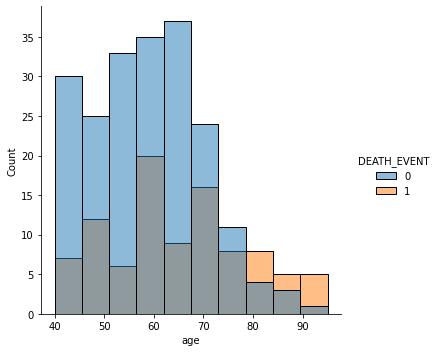

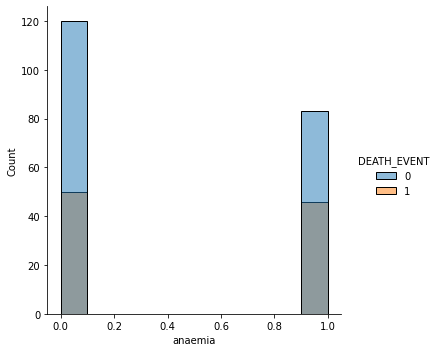

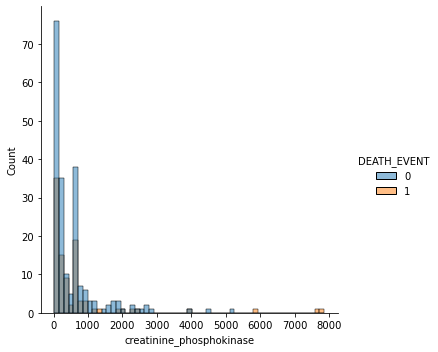

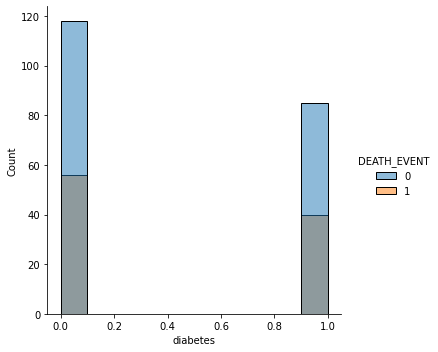

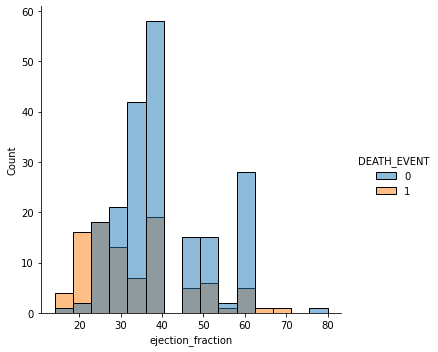

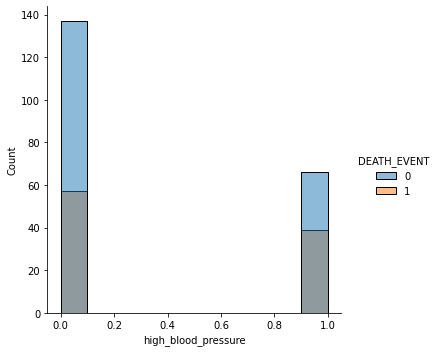

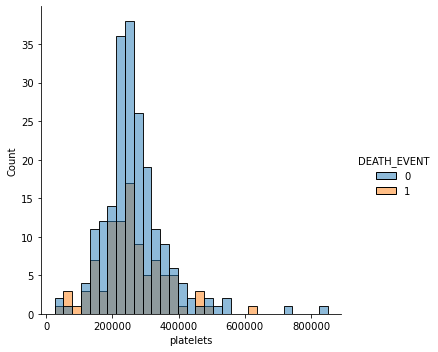

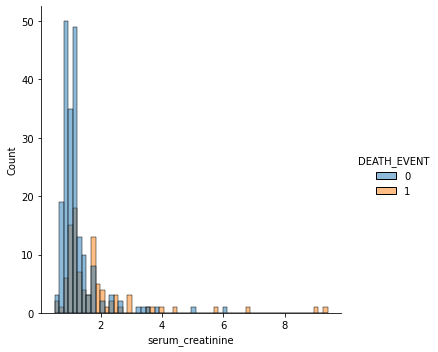

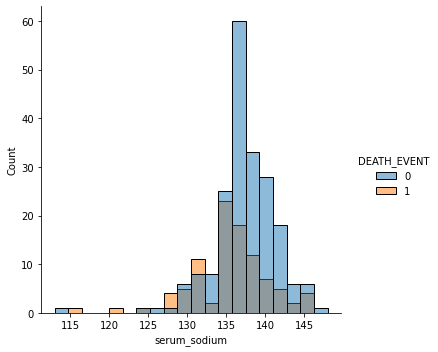

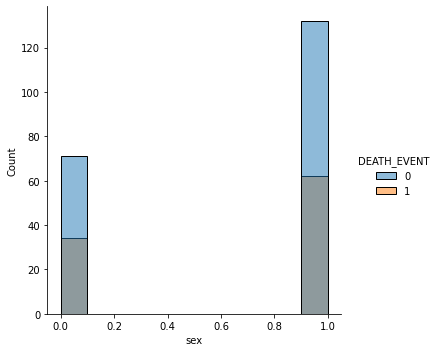

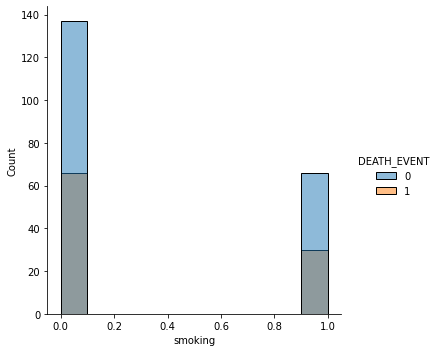

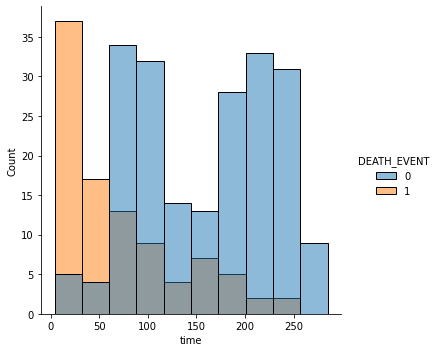

In [4]:
for col in df.columns[:-1]:
    sns.displot(df, x=col, hue='DEATH_EVENT')
    plt.show()

In [5]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
X = df.loc[:, ~df.columns.isin(['DEATH_EVENT', 'time'])]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [7]:
pipe = Pipeline([
        ('scale', MinMaxScaler()),
        ('clf', XGBClassifier())])

In [8]:
param_grid = dict(clf__max_depth=[2, 4, 6, 10, 20])

In [9]:
grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    cv=5,
                    n_jobs=-1,
                    scoring='f1')

In [10]:
%%time
grid.fit(X_train, y_train)

CPU times: user 107 ms, sys: 36.9 ms, total: 144 ms
Wall time: 1.35 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                     

In [11]:
grid.best_params_

{'clf__max_depth': 20}

In [12]:
pipe.set_params(**grid.best_params_)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=20,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

In [13]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 91.8 ms, sys: 2.95 ms, total: 94.7 ms
Wall time: 30.6 ms


Pipeline(steps=[('scale', MinMaxScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=20, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [14]:
fin_preds = pipe.predict_proba(X_test)[:, 1]

In [15]:
model_precision, model_recall, model_thresholds = precision_recall_curve(y_test, fin_preds)

model_fscore = (2 * model_precision * model_recall) / (model_precision + model_recall)
# locate the index of the largest f score
ix_model = np.argmax(model_fscore)
print('XGB best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (model_thresholds[ix_model], 
                                                                        model_fscore[ix_model],
                                                                        model_precision[ix_model],
                                                                        model_recall[ix_model]))

XGB best Threshold=0.121942, F-Score=0.706, Precision=0.600, Recall=0.857


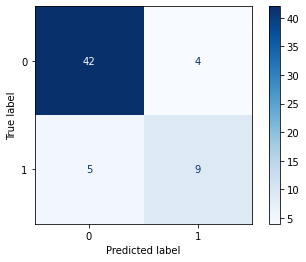

In [16]:
plot_confusion_matrix(pipe, X_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

**Построить важности признаков для:**
1. Всего тестового набора данных (summary_plot - дать интерпретацию)
2. Для топ 10% (сортировка по убыванию вероятности - таргета)


In [17]:
explainer = shap.TreeExplainer(pipe['clf'])
shap_values = explainer.shap_values(X_train)

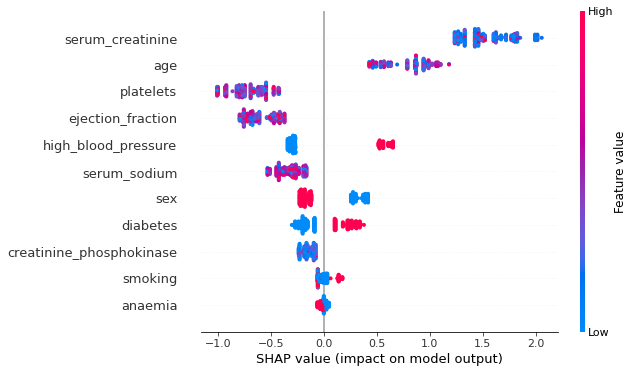

In [18]:
shap.summary_plot(shap_values, X_train)

Из графика видно что на летальный исход сильнее всего влияют возраст и serum_creatinine

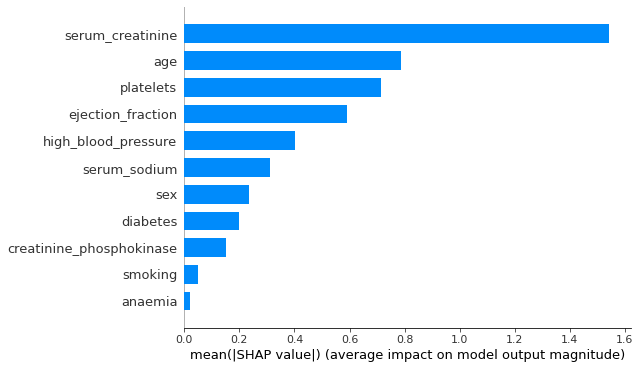

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

**Для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат**

In [20]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Видно что для этого предсказания serum_creatinine, high_blood_pressure и age внесли большой вклад в сторону летального исхода